In [17]:
import scanpy as sc
import numpy as np
import torch

import os,sys
pwd = '/home/lijiahao/workbench/SAVE/'
sys.path.append(pwd)
os.chdir(pwd)

from model.save_model import SAVE
from model.utils.process_h5ad import batch_scale, preprocessing_rna

In [18]:
# download the via link: https://www.dropbox.com/s/wk5zewf2g1oat69/train_pbmc.h5ad?dl=1 and https://www.dropbox.com/s/nqi971n0tk4nbfj/valid_pbmc.h5ad?dl=1

In [19]:
tran_data = sc.read_h5ad('train_pbmc.h5ad')
valid_data = sc.read_h5ad('valid_pbmc.h5ad')
adata = sc.concat([tran_data, valid_data])

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [20]:
adata.obs["batch"] = adata.obs['condition']
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="batch", subset=True)

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
# split new test and train data
test_celltype = 'CD8T'
test_data = adata[adata.obs['cell_type'] == test_celltype]
train_data = adata[adata.obs['cell_type'] != test_celltype]

In [22]:
test_data

View of AnnData object with n_obs × n_vars = 1237 × 2000
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [23]:
test_data, _ = batch_scale(test_data)
train_data, _ = batch_scale(train_data)

batch_scale:   0%|                                        | 0/1 [00:00<?, ?it/s]/mnt/sdc/lijiahao/workbench/SAVE/model/utils/process_h5ad.py:79: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  adata.X[idx[i * chunk_size : (i + 1) * chunk_size]] = scaler.transform(
batch_scale: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


In [24]:
device = torch.device('cuda:0')
seed = 1202
kwargs = {
    "device": device,
    "seed": seed,
    "is_data_scaled": True,
}
import yaml

with open(pwd + "/model_setting.yml", "r") as f:
    setting = yaml.safe_load(f)

kwargs.update(setting["SAVE-B"]["train"])
kwargs.update(setting["SAVE-B"]["model"])

In [25]:
from model.save_model import SAVE

save_model = SAVE(
    adata=train_data.copy(),
    is_initialized=True,
    condition_cols=['condition'],
    **kwargs,
    )


total col comb is: 1
initialze model weight with seed 1202


In [26]:
save_model.train(**kwargs)
save_model.save_ckpt('ckpt/CD8T_perturb.pt')

cond encoding max: 1 min:0
total iter: 3600


100%|███████| 200/200 [08:42<00:00,  2.61s/it, recon_loss=120.335,kl_loss=2.990]


save ckpt to ckpt/CD8T_perturb.pt!


In [27]:
save_model.load_ckpt('ckpt/CD8T_perturb.pt')

successfully load ckpt/CD8T_perturb.pt!


In [28]:
input_data = test_data[test_data.obs['condition'] == 'control']
target_data = test_data[test_data.obs['condition'] == 'stimulated']

In [29]:
input_data

View of AnnData object with n_obs × n_vars = 643 × 2000
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [30]:
pred_data = save_model.transfer_cond(input_data, target_cond={'condition': 'stimulated'})

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


In [31]:
pred_data.obs['condition'] = 'pred'

In [32]:
merge_data = sc.concat([input_data, target_data, pred_data])

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


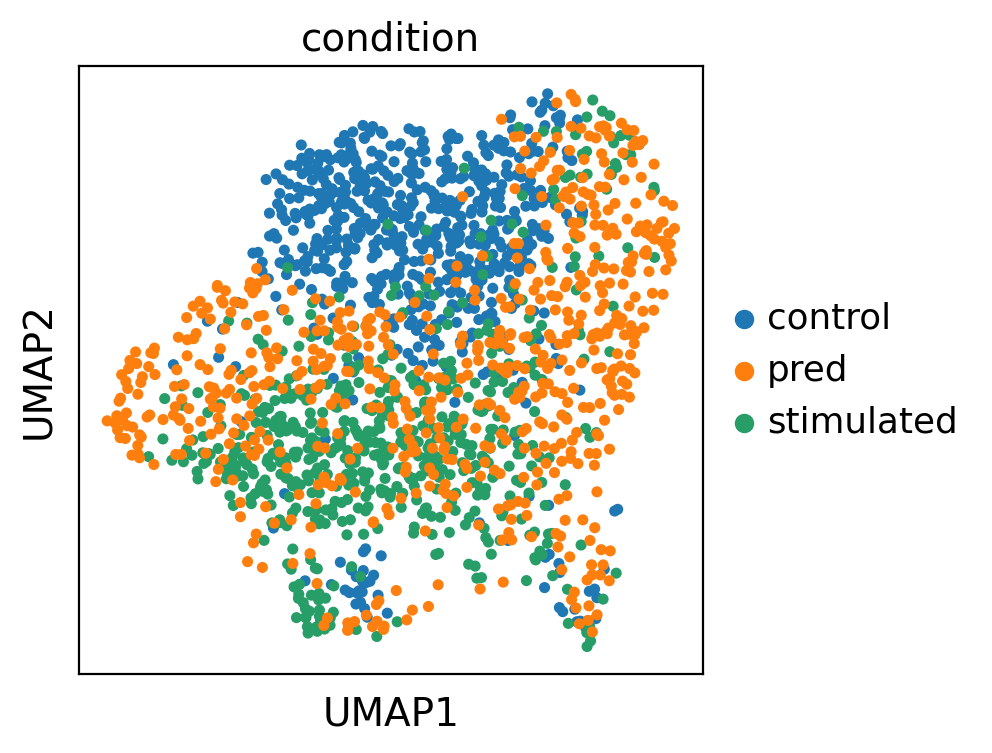

In [33]:
sc.set_figure_params(dpi=100)
sc.pp.pca(merge_data)
sc.pp.neighbors(merge_data)
sc.tl.umap(merge_data)
sc.pl.umap(merge_data, color=['condition'])